In [36]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

import keras_tuner as kt
from sklearn.model_selection import train_test_split

# Other
from pathlib import Path
import os
import math

In [37]:
train_images_path = Path("/Users/anubhavshroti/Desktop/AI Solutions/data Day 20/training_images")
test_images_path = Path("/Users/anubhavshroti/Desktop/AI Solutions/data Day 20/testing_images")

In [38]:
train = pd.read_csv("/Users/anubhavshroti/Desktop/AI Solutions/data Day 20/train_solution_bounding_boxes (1).csv")
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train = train.groupby('image')[['xmin', 'ymin', 'xmax', 'ymax']].apply(lambda x: x.values.flatten().tolist()).reset_index()
train.columns = ['image_name','coordinates']
max_length = train['coordinates'].str.len().max()
train['coordinates'] = train['coordinates'].apply(lambda x: x + [0] * (max_length - len(x)))

In [39]:
test_images = []
for filename in os.listdir(test_images_path):
    img_path = os.path.join(test_images_path, filename)
    image = cv2.imread(img_path) / 255.
    test_images.append(image)

In [40]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)
    
    # Draw the bounding boxes
    while len(bbox_coords) > 0:
        xmin, ymin, xmax, ymax = bbox_coords[:4]
        bbox_coords = bbox_coords[4:]
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)
        
    while len(pred_coords) > 0:
        xmin, ymin, xmax, ymax = pred_coords[:4]
        pred_coords = pred_coords[4:]
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
    
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
def display_image_from_file(name, bbox_coords=[], path=train_images_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)
    
def display_from_dataframe(row, path=train_images_path):
    display_image_from_file(row['image_name'], bbox_coords=row.coordinates, path=path)
    

def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))
    
    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]
    
    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])
        

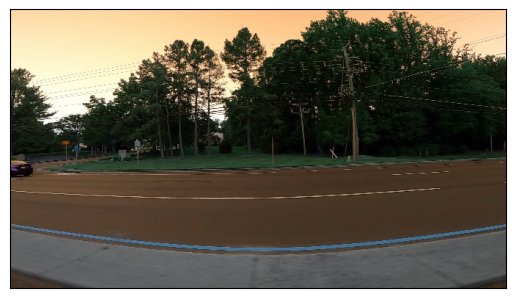

In [41]:
display_image_from_file("vid_4_10520.jpg")

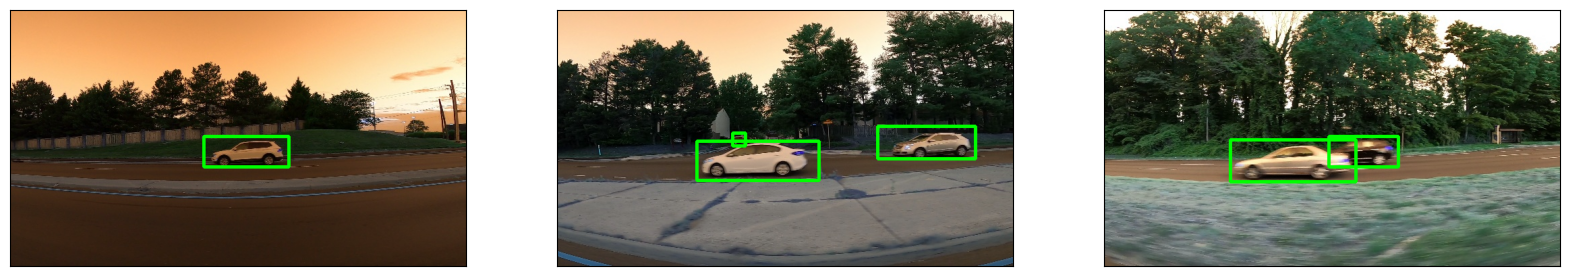

In [42]:
display_grid()

In [43]:
def data_generator(df=train, batch_size=16, path=train_images_path):
    while True:        
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, max_length))
        
        for i in range(batch_size):
                rand_index = np.random.randint(0, train.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(path/row.image_name)) / 255.
                bounding_box_coords[i] = np.array(row.coordinates)
                
        yield {'image': images}, {'coords': bounding_box_coords}
        

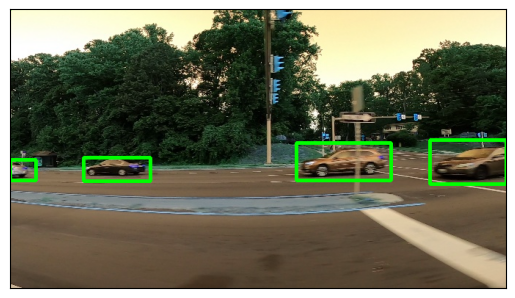

In [44]:
# Test the generator
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

display_image(img, bbox_coords=bbox_coords, norm=True)

In [45]:
def model_builder(hp):
    # Initialize the sequiential model
    model = tf.keras.Sequential()
    model.add(Input(shape=[380, 676, 3], name='image'))
    # Define the number of convolutional layers to use and were the powers start   
    hp_convolutional_layers = hp.Int('convolutional_layers', min_value=6, max_value=12, step=2)
    hp_power_filter = hp.Int('first_power_filter', min_value=3, max_value=5, step=1)
    for i in range(hp_convolutional_layers):
        model.add(Conv2D(2**hp_power_filter, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(2, padding='same'))
        hp_power_filter = min(10,hp_power_filter + 1)

    # Añadir las capas de aplanado y las capas deansas y de salida
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(max_length, activation='relu', name='coords'))

    # Compilamos el modelo
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                  loss='mse',
                  metrics=['accuracy'])
    
    return model

In [46]:
# Some functions to test the model. These will be called every epoch to display the current performance of the model
def test_model(model, datagen):
    example, label = next(datagen)
    
    X = example['image']
    y = label['coords']
    
    pred_bbox = model.predict(X)[0]
    
    img = X[0]
    gt_coords = y[0]
    
    display_image(img, bbox_coords=gt_coords, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)
    
    plt.figure(figsize=(15,7))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        test_model(model, datagen)    
    plt.show()
    
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)


In [51]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# instantiate the tuner and perform hypertuning
tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=5,
                     factor=3)
with tf.device('/GPU:0'):
    tuner.search(data_generator(), epochs=5, steps_per_epoch = 500, callbacks=[early_stopping,ShowTestImages()])


# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f'Number of convilutional layers: {best_hps.get("convolutional_layers")}')
print(f'Filters in the first covolutional layer: {2**best_hps.get("first_power_filter")}')

Reloading Tuner from ./untitled_project/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
8                 |6                 |convolutional_layers
4                 |4                 |first_power_filter
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
0                 |0                 |tuner/round



Epoch 1/2
101/500 [=====>........................] - ETA: 40:08:38 - loss: 11491.9707 - accuracy: 0.4455

KeyboardInterrupt: 

In [ ]:
# build the best model using the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

model.summary()


In [ ]:
# train the model
with tf.device('/GPU:0'):
    _= model.fit(data_generator(), epochs=15, steps_per_epoch=500, callbacks=[ShowTestImages()])

In [ ]:
model.save('car-object-detection.h5')